# CEAD ML project on the Ringenprinter. 
#### Welcome to the Notebook in which I will explore and visualize the data of the collected data.  

#### Material: PET-G 30% Glass Fiber
#### Dataset: PETG30GF test set, 31-10-2022 from 16:00 to 16:34




## Imports and Settings

In [1]:
# imports
# system related
import sys
import subprocess

# basics
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import itertools
from datetime import datetime, time

# ml related
import sklearn as sk
import torch
import torch.nn as nn

# import scripts and functions
from functions_old import *


print('imports succesfull')

imports succesfull


In [2]:
# settings of pandas, usefull for data exploration
pd.options.display.width = 0
pd.set_option('display.max_rows', 100)
pd.set_option('display.min_rows', 50)
# if reset is required:
# pd.reset_option('all')

## Import and Preprocessing data

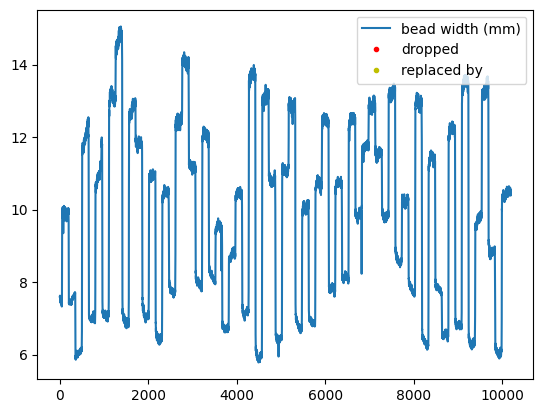

median filt ACTIVATED
import and preprocessing data succesfull


In [3]:
# Defining import variables, _s stands for small
loc_s = '../data/petg30gf_test_set_31-10_15.57-16.44.csv'
start_s = '2022-10-31 16:00:00.000'
end_s = '2022-10-31 16:34:00.000'

# import, filter, outlier replacement and median filtering on bead_width (mm)
df_s = import_csv_filt(loc_s, start_s, end_s, plot_outliers=True, outlier_window = 8)

df_s_no_filt = import_csv_filt(loc_s, start_s, end_s, median_filt=False, outlier_window = 8)

print('import and preprocessing data succesfull')

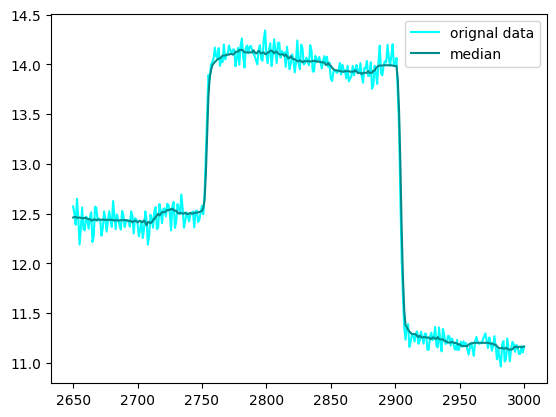

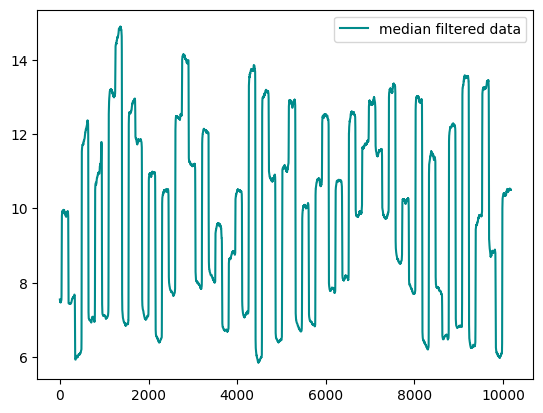

In [4]:
filter_length = 20
head_tails = int(filter_length/2)

bead_gauss = df_s['bead_width (mm)'].rolling(window=filter_length, win_type='gaussian', center=True).mean(std=5)
bead_median = df_s['bead_width (mm)'].rolling(window=filter_length, center=True).median()


plt.plot(df_s_no_filt.loc[2650:3000, 'bead_width (mm)'], 'cyan', label='orignal data')
plt.plot(df_s.loc[2650:3000, 'bead_width (mm)'], 'darkcyan', label='median')
plt.legend()
plt.show()

plt.plot(df_s.loc[:, 'bead_width (mm)'], 'darkcyan', label='median filtered data')
plt.legend()
plt.show()


## Exploration

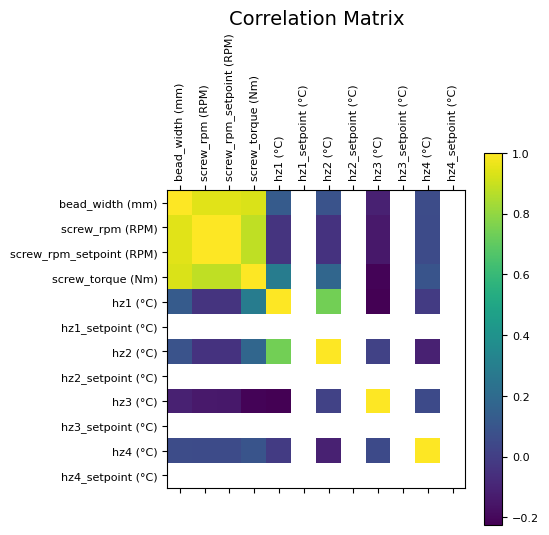

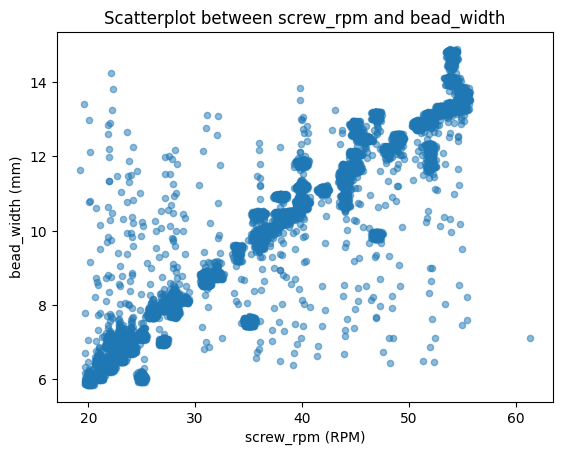

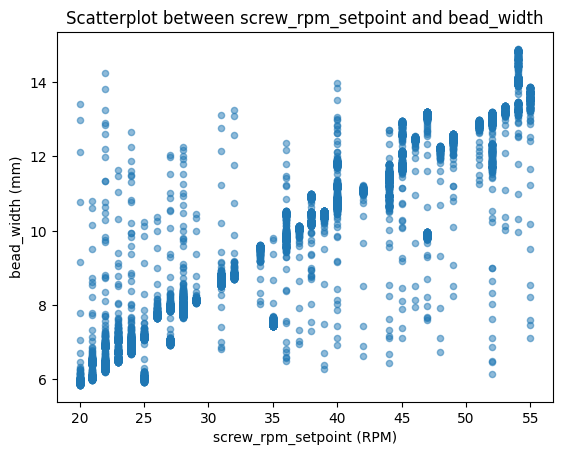

<Figure size 600x500 with 0 Axes>

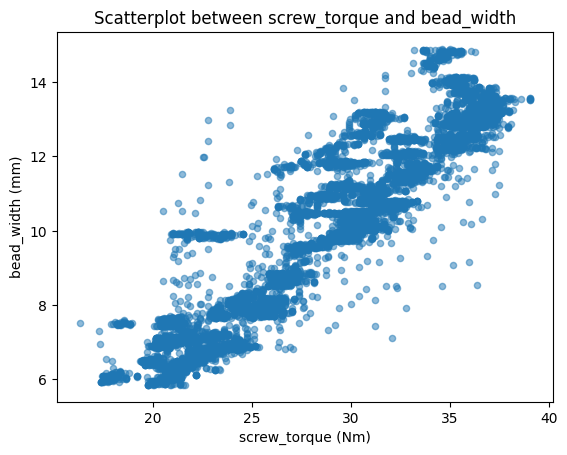

In [5]:
# plots

plt.matshow(df_s.corr())
plt.xticks(range(df_s.select_dtypes(['number']).shape[1]), df_s.select_dtypes(['number']).columns, fontsize=8, rotation=90)
plt.yticks(range(df_s.select_dtypes(['number']).shape[1]), df_s.select_dtypes(['number']).columns, fontsize=8)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=8)
plt.title('Correlation Matrix', fontsize=14)
plt.show()

df_s.plot.scatter(x='screw_rpm (RPM)', y='bead_width (mm)', alpha = 0.5)
plt.title('Scatterplot between screw_rpm and bead_width')
plt.show()

df_s.plot.scatter(x='screw_rpm_setpoint (RPM)', y='bead_width (mm)', alpha = 0.5)
plt.title('Scatterplot between screw_rpm_setpoint and bead_width')
plt.show()


f = plt.figure(figsize=(6, 5))
df_s.plot.scatter(x='screw_torque (Nm)', y='bead_width (mm)', alpha = 0.5)
plt.title('Scatterplot between screw_torque and bead_width')
plt.show()


## Filtering on used features only and adding history to selected features

In [6]:
# filtering dataset so only used columns are present
columns_to_keep = ['bead_width (mm)', 'screw_rpm (RPM)']

df_s_lean = df_s[columns_to_keep]

# add history of some columns
to_expand_columns = ['screw_rpm (RPM)']
df_s_lean = df_add_column_history(df_s_lean, to_expand_columns, n_columns=0, steps=2)

## Preparing data for ML use

In [7]:
# splitting features from supervisory data
X, y = split_to_np_feat_and_ans(df_s_lean)

# scale data and normalise data

# splitting the Train and Test data
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

## Exploring ML models

#### Linear Regression

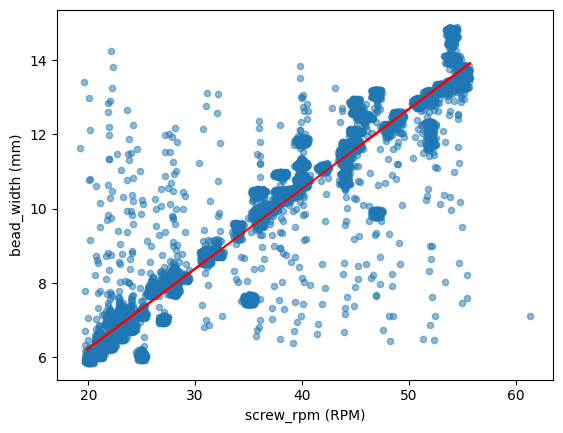

mean squared error is :  0.5931928323923678
          r2 score is :  0.9042201063959593

      std of error is :  0.76975552159532


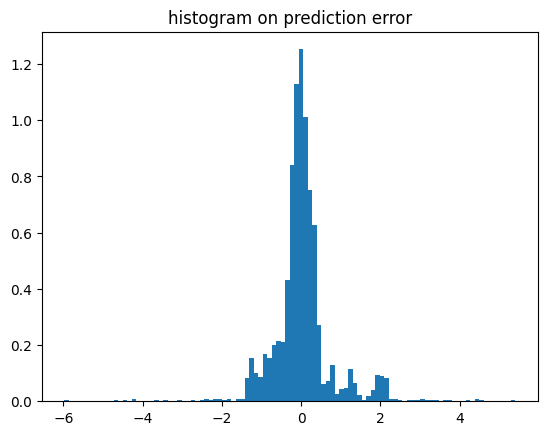

1

In [8]:
# imports
from sklearn.linear_model import LinearRegression

# create model
clf_lin = LinearRegression() 

# train model
clf_lin.fit(X, y)


# predict on test set
y_pred = clf_lin.predict(X_test)


# plot result
df_s_lean.plot.scatter(x='screw_rpm (RPM)', y='bead_width (mm)', alpha = 0.5)
plt.plot(X_test, y_pred, 'r')
plt.show()



give_prediction_score(y_test, y_pred)


#### True outcome vs. the expected outcome of the linear model 

coefficients: 
 0.21485850403156942
intercept: 
 1.9404366364861643


vals 8190 and 8300: 
6.486000000000001
6.2


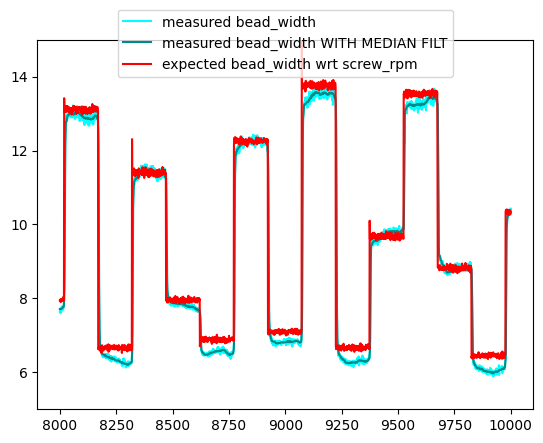

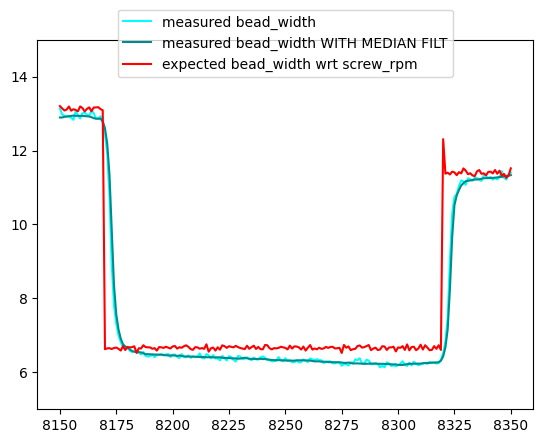

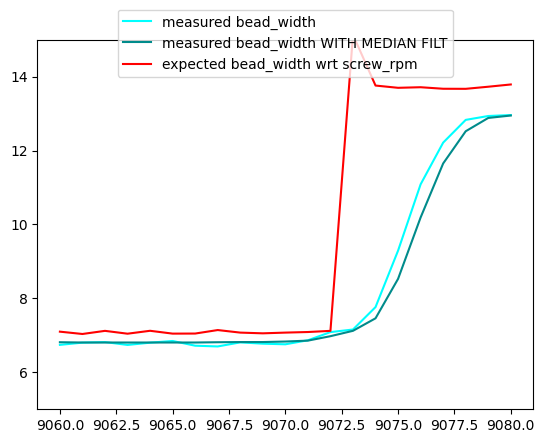

In [9]:
# fit parameters
a = clf_lin.coef_[0]
b = clf_lin.intercept_

# print
print("coefficients: \n", a)
print("intercept: \n", b)

# making database with expected bead width
df_eo = df_s.copy(deep=True)
df_eo['expected_bead_width (mm)'] = df_eo['screw_rpm (RPM)'] * a + b

# making copy of original df and aligning index
df_s_copy = df_s.copy(deep=True)
# df_s_copy.drop(df_s_copy.head(head_tails).index.union(df_s_copy.tail(head_tails).index), inplace=True)
# df_s_copy = df_s_copy.reset_index()

print('\n\nvals 8190 and 8300: ')
print(df_eo.loc[8190, 'bead_width (mm)'])
print(df_eo.loc[8300, 'bead_width (mm)'])

# plotting
start =  8000
stop  = 10000

plt.plot(df_s_no_filt.loc[start:stop, 'bead_width (mm)'], 'cyan', label='measured bead_width')
plt.plot(df_eo.loc[start:stop, 'bead_width (mm)'], 'darkcyan', label='measured bead_width WITH MEDIAN FILT')
plt.plot(df_eo.loc[start:stop, 'expected_bead_width (mm)'], 'red', label='expected bead_width wrt screw_rpm')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.10), fancybox=True)
plt.ylim(5,15)
plt.show()

start =  8150
stop  = 8350

plt.plot(df_s_no_filt.loc[start:stop, 'bead_width (mm)'], 'cyan', label='measured bead_width')
plt.plot(df_eo.loc[start:stop, 'bead_width (mm)'], 'darkcyan', label='measured bead_width WITH MEDIAN FILT')
plt.plot(df_eo.loc[start:stop, 'expected_bead_width (mm)'], 'red', label='expected bead_width wrt screw_rpm')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.10), fancybox=True)
plt.ylim(5,15)
plt.show()

start =  9060
stop  = 9080

plt.plot(df_s_no_filt.loc[start:stop, 'bead_width (mm)'], 'cyan', label='measured bead_width')
plt.plot(df_eo.loc[start:stop, 'bead_width (mm)'], 'darkcyan', label='measured bead_width WITH MEDIAN FILT')
plt.plot(df_eo.loc[start:stop, 'expected_bead_width (mm)'], 'red', label='expected bead_width wrt screw_rpm')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.10), fancybox=True)
plt.ylim(5,15)
plt.show()



In [10]:
loc_flat = '../data/petg30gf_test_set_31-10_15.57-16.44.csv'
start_flat = '2022-10-31 16:34:00.000'
end__flat = '2022-10-31 16:44:00.000'

df_flat = import_csv_filt(loc_flat, start_flat, end_flat)
df_flat_no_filt = import_csv_filt(loc_flat, start_flat, end_flat, median_filt=False)
df_flat['expected_bead_width (mm)'] = df_flat['screw_rpm_setpoint (RPM)'] * a + b +.75  # sorry, i'm cheating a little here. 

plt.plot(df_flat_no_filt.loc[:, 'bead_width (mm)'], 'cyan', label='measured bead_width')
plt.plot(df_flat.loc[:, 'bead_width (mm)'], 'darkcyan', label='measured bead_width WITH MEDIAN FILT')
plt.plot(df_flat.loc[:, 'expected_bead_width (mm)'], 'red', label='expected bead_width wrt screw_rpm_setpoint')
plt.legend(loc='lower center', fancybox=True)
plt.show()


NameError: name 'end_flat' is not defined